# Preprocess FaceID Dataset

In [34]:
import os, sys, shutil, requests, zipfile, io, re
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm as pbar
from PIL import Image, ImageOps
sys.path.insert(0, '/home/huy/Projects/FaceID')

In [35]:
data_dir = '/data/huy/faceid/'

## Download dataset

Dataset link http://www.vap.aau.dk/rgb-d-face-database/

In [36]:
train_url = 'https://rutgers.box.com/shared/static/vfaxy3y1otrvn5dbvbxdg3unmvyun7yg.zip'
val_url = 'https://rutgers.box.com/shared/static/smgbvw9v5qemc196072z51x7kwfaxn4b.zip'

In [37]:
def download(url):
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in Mebibyte
    total_size = int(r.headers.get('content-length', 0))
    block_size = 2**20 # Mebibyte
    t = pbar(total=total_size, unit='MiB', unit_scale=True)

    header = r.headers['content-disposition']
    file_name = re.findall("filename\*=UTF-8\'\'(.+)", header)[0]

    with open(file_name, 'wb') as f:
        for data in r.iter_content(block_size):
            t.update(len(data))
            f.write(data)
    t.close()

    if total_size != 0 and t.n != total_size:
        raise Exception('Error, something went wrong')
        
    print('Download successful. Unzipping ' + file_name)
    file_path = os.path.join(os.getcwd(), file_name)
    
    extract_dir = os.getcwd()
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        print('Unzip file successful!')

In [38]:
# download(val_url)

In [39]:
# download(train_url)

## Process data

In [40]:
def crop_center(img, cropx, cropy):
    y,x = img.shape[0], img.shape[1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [41]:
def process_data(raw_dir, processed_dir):
    """
    Stack RGB and D images to a numpy array of shape 400 x 400 x 4
    Save images in format of personID_poseID
    """    
    all_people = [x for x in os.listdir(raw_dir) if '2012' in x]
    for person_id, a_person in enumerate(pbar(all_people)):
        
        all_poses = [x for x in os.listdir(os.path.join(raw_dir, a_person)) if '.bmp' in x]
        for pose_id, a_pose in enumerate(all_poses):
            photo_id = a_pose[:-5] # drop 'c.bmp'

            photo_rgb = photo_id + 'c.bmp'
            photo_rgb = Image.open(os.path.join(raw_dir, a_person, photo_rgb))
            photo_rgb = np.array(photo_rgb.convert("RGB").resize((640, 480)))

            photo_depth = photo_id + 'd.dat'
            photo_depth = np.loadtxt(os.path.join(raw_dir, a_person, photo_depth))
            photo_depth = photo_depth - photo_depth.min()

            # Align RGB and D
            photo_depth = np.pad(photo_depth, [(0, 0), (20, 0)], mode='constant')
            photo_depth = photo_depth[:,:-20]
            photo_depth = np.expand_dims(photo_depth, -1)

            # Save to disk
            rgbd = np.concatenate((photo_rgb, photo_depth), axis=2)
            rgbd = np.uint8(rgbd)
            rgbd = crop_center(rgbd, 400, 400)
            name = 'person' + str(person_id) + '_pose' + str(pose_id) + '.npy'
            np.save(os.path.join(processed_dir, name), rgbd)

In [42]:
process_data(data_dir + 'train_raw', data_dir + 'train')

100%|██████████| 26/26 [03:12<00:00,  7.39s/it]


In [43]:
process_data(data_dir + 'val_raw', data_dir + 'val')

100%|██████████| 5/5 [00:36<00:00,  7.39s/it]


In [ ]:
# os.mkdir('train')
# process_data('train_raw', 'train')

# os.mkdir('val')
# process_data('val_raw', 'val')

In [ ]:
# Move data to desire place
# os.mkdir(data_dir)
# shutil.move('train_raw', data_dir)
# shutil.move('val_raw', data_dir)
# shutil.move('train', data_dir)
# shutil.move('val', data_dir)

# Display a test RGBD image

In [44]:
test_img_path = os.path.join(data_dir, 'val/person0_pose0.npy')
test_img = np.load(test_img_path)

In [45]:
rgb = test_img[:,:,:3]/255.0
d = test_img[:,:,3]/255.0

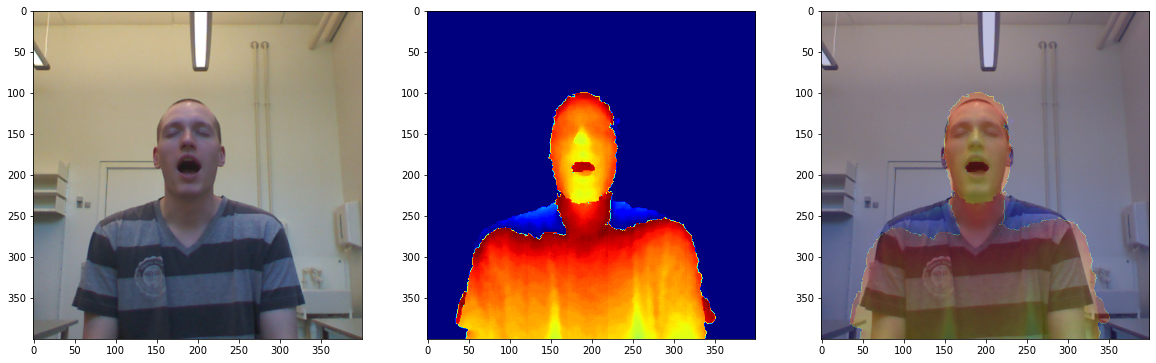

In [46]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 60)

axs[0].imshow(rgb)
axs[1].imshow(d, cmap='jet')
axs[2].imshow(rgb)
axs[2].imshow(d, cmap='jet', alpha=0.25)

plt.show()